# Exploring and cleaning the Union of Concerned Scientists database of Earth Satellites

The Union of Concerned Scientists maintains a database of ~1000 Earth satellites:

http://www.ucsusa.org/nuclear-weapons/space-weapons/satellite-database.html

For the majority of satellites, it includes kinematic, material, electrical, political, functional, and economic characteristics, such as dry mass, launch date, orbit type, country of operator, and purpose. The data appears to have been mirrored on other satellite search websites, e.g. http://satellites.findthedata.com/ .

This iPython notebook describes a sequence of interactions with a snapshot of this database using the bayeslite implementation of BayesDB, using the Python bayeslite client library. The snapshot includes a population of satellites defined using the UCS data as well as a constellation of generative probabilistic models for this population.

We have already analyzed this population of satellite data. We first download the results of that analysis:

In [1]:
import os
import subprocess
if not os.path.exists('satellites.bdb'):
    subprocess.check_call(['curl', '-O', 'http://probcomp.csail.mit.edu/bayesdb/downloads/satellites.bdb'])

In [2]:
# Load the bayeslite client library
import bayeslite
import bdbcontrib
from bdbcontrib import Population

# Load the satellites snapshot into a local instance of bayeslite
satellites = Population(name='satellites', bdb_path='satellites.bdb')


BQL [SELECT * FROM bayesdb_generator] ()

## Querying the data using SQL

Before querying the implications of a population, it can be useful to look at a sample of the raw data and metadata. This can be done using a combination of ordinary SQL and convenience functions built into bayeslite. We start by finding one of the most well-known satellites, the International Space Station:

In [3]:
satellites.q("""
SELECT * FROM satellites 
WHERE Name LIKE 'International Space Station%'
""").transpose()

BQL [
SELECT * FROM satellites 
WHERE Name LIKE 'International Space Station%'
] ()

,0
Name,International Space Station (ISS [first elemen...
Country_of_Operator,Multinational
Operator_Owner,NASA/Multinational
Users,Government
Purpose,Scientific Research
Class_of_Orbit,LEO
Type_of_Orbit,Intermediate
Perigee_km,401
Apogee_km,422
Eccentricity,0.00155


In [4]:
satellites.q("""SELECT COUNT(*) FROM satellites;""")

BQL [SELECT COUNT(*) FROM satellites;] ()

,"""COUNT""(*)"
0,1167


In [5]:
satellites.q("""SELECT * FROM satellites WHERE Name LIKE '%GPS%'""").transpose()

BQL [SELECT * FROM satellites WHERE Name LIKE '%GPS%'] ()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Name,"Navstar GPS II-10 (Navstar SVN 23, PRN 32, US...","Navstar GPS II-14 (Navstar SVN 26, PRN 26, USA...","Navstar GPS II-21 (Navstar SVN 39, PRN 09, USA...","Navstar GPS II-23 (Navstar SVN 34, PRN 04, USA...","Navstar GPS II-24 (Navstar SVN 36, PRN 06, USA...","Navstar GPS II-25 (Navstar SVN 33, PRN 03, USA...","Navstar GPS II-26 (Navstar SVN 40, PRN 10, USA...","Navstar GPS II-28 (Navstar SVN 38, PRN 08, USA...","Navstar GPS II-35 (Navstar SVN 35, PRN 30, USA...","Navstar GPS IIF-1 (Navstar SVN 62, PRN 25, USA...",...,"Navstar GPS IIR-7 (Navstar SVN 54, PRN 18, USA...","Navstar GPS IIR-8 (Navstar SVN 56, PRN 16, USA...","Navstar GPS IIR-9 (Navstar SVN 45, PRN 21, USA...","Navstar GPS IIR-M-1 (Navstar SVN 53, PRN 17, U...","Navstar GPS IIR-M-2 (Navstar SVN 52, PRN 31, U...","Navstar GPS IIR-M-3 (Navstar SVN 58, PRN 12, U...","Navstar GPS IIR-M-4 (Navstar SVN 55, PRN 15, U...","Navstar GPS IIR-M-5 (Navstar SVN 57, PRN 29, U...","Navstar GPS IIR-M-6 (Navstar SVN 48, PRN 07, U...","Navstar GPS IIR-M-8 (Navstar SVN 50, PRN 05, U..."
Country_of_Operator,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA,...,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA
Operator_Owner,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,...,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force,DoD/US Air Force
Users,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,...,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial,Military/Commercial
Purpose,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,...,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning,Navigation/Global Positioning
Class_of_Orbit,MEO,MEO,MEO,MEO,MEO,MEO,MEO,MEO,MEO,MEO,...,MEO,MEO,MEO,MEO,MEO,MEO,MEO,MEO,MEO,MEO
Type_of_Orbit,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
Perigee_km,19781,19959,20120,20104,19986,20080,20134,19912,20109,20188,...,20104,20155,20063,20142,20020,20206,20149,20150,20135,20160
Apogee_km,20582,20403,20244,20260,20315,20284,20227,20449,20257,20224,...,20266,20344,20433,20221,20342,20366,20213,20311,20152,20209
Eccentricity,0.01508,0.00836,0.00234,0.00294,0.0062,0.00384,0.00175,0.01011,0.00279,0.00068,...,0.00305,0.00355,0.00695,0.00149,0.00606,0.003,0.00121,0.00303,0.00032,0.00092


In [6]:
satellites.q("""
SELECT name, dry_mass_kg, period_minutes, class_of_orbit FROM satellites 
ORDER BY period_minutes LIMIT 10;
""")

BQL [
SELECT name, dry_mass_kg, period_minutes, class_of_orbit FROM satellites 
ORDER BY period_minutes LIMIT 10;
] ()

,Name,Dry_Mass_kg,Period_minutes,Class_of_Orbit
0,"Advanced Orion 5 (NRO L-32, USA 223)",NaN,NaN,GEO
1,"IGS-8B (Information Gathering Satellite 8B, IG...",NaN,NaN,LEO
2,Interstellar Boundary EXplorer (IBEX),NaN,0.22,Elliptical
3,Spektr-R/RadioAstron,NaN,0.22,Elliptical
4,"SDS III-6 (Satellite Data System) NRO L-27, Gr...",NaN,14.36,GEO
5,"Advanced Orion 6 (NRO L-15, USA 237)",NaN,23.94,GEO
6,"SDS III-7 (Satellite Data System) NRO L-38, Dr...",NaN,23.94,GEO
7,RISat-2 (Radar Imaging Satellite 2),NaN,41.20,LEO
8,Kuaizhou-1 (KZ-1),NaN,90.61,LEO
9,X37-B OTV-1 (USA 240),NaN,91.54,LEO


bayeslite includes statistical graphics procedures designed for easy use with data extracted from an SQL database. Consider the problem of visualizing a table with two columns: `dry_mass_kg`, a `NUMERICAL` column, and `class_of_orbit`, a `CATEGORICAL` column. The `bdbcontrib.histogram` procedure renders this data by producing overlaid histograms, one per distinct value of `class_of_orbit`.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

BQL [SELECT dry_mass_kg, class_of_orbit FROM satellites] ()

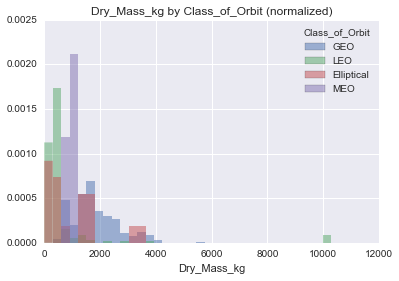

In [8]:
satellites.histogram("""SELECT dry_mass_kg, class_of_orbit FROM satellites""", 
                     nbins=35, normed=True);

## Querying the implications using BQL — _What if?_ questions

Consider the following "what if?" question about satellites:

`Suppose there is a satellite in geosynchronous orbit that we know has a dry mass of 500 kilograms. What is its probable purpose? and what countries might be operating it?`

In some applications, these "what if?" scenarios may be of intrinsic interest. They also provide a way for domain experts to scrutinize the models that come with this snapshot, by qualitatively checking their implications via simulated examples.

It is straightforward to pose this question using BQL:

In [9]:
satellites.q("""DROP TABLE IF EXISTS "satellite_purpose";""");
satellites.q("""
CREATE TEMP TABLE IF NOT EXISTS satellite_purpose AS
    SIMULATE country_of_operator, purpose FROM %g
    GIVEN Class_of_orbit = 'GEO', Dry_mass_kg = 500 
    LIMIT 1000;
""");

BQL [DROP TABLE IF EXISTS "satellite_purpose";] ()

BQL [
CREATE TEMP TABLE IF NOT EXISTS satellite_purpose AS
 SIMULATE country_of_operator, purpose FROM "satellites_cc"
 GIVEN Class_of_orbit = 'GEO', Dry_mass_kg = 500 
 LIMIT 1000;
] ()

Note that everything after the `AS` is a perfectly valid query. `CREATE TEMP TABLE satellite_purpose AS` saves the result of the query that follows it into a table called `satellite_purpose` which we can refer to later. Temporary
tables are destroyed when the session is closed.

The `%g` specifies the set of generative population models created for this population during the analysis step that we performed for you on this population, and stored in the bdb file that we downloaded in the first step of the notebook. Creating those models is beyond the scope of this segment of the tutorial. The important thing to note is that one has to use `%g` (or explicitly the name of the set of models, in this case `satellites_cc` as we can see in the BQL echoed above) whenever we are trying to `SIMULATE` or `ESTIMATE` from those models.

To inspect the results, we first create a derived `Country-Purpose` variable, aggregate over it, and sort the results, all using SQL, and visualize it using `bdbcontrib.barplot`:

BQL [
SELECT country_of_operator || "--" || purpose AS "Country-Purpose", 
 COUNT("Country-Purpose") AS frequency
FROM satellite_purpose
 GROUP BY "Country-Purpose"
 ORDER BY frequency DESC
LIMIT 20;
] ()

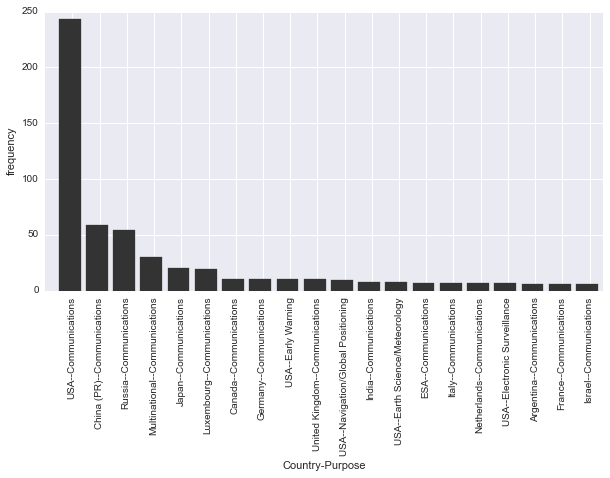

In [10]:
satellites.barplot("""
SELECT country_of_operator || "--" || purpose AS "Country-Purpose", 
    COUNT("Country-Purpose") AS frequency
FROM satellite_purpose
    GROUP BY "Country-Purpose"
    ORDER BY frequency DESC
LIMIT 20;
""");

What if you approached this question by querying the data and not its implications? One approach would be to find existing satellites that are in `GEO` and have a `dry_mass_kg` that is close to 500:

In [11]:
satellites.q("""
SELECT country_of_operator, purpose, Class_of_orbit, Dry_mass_kg
    FROM satellites
        WHERE Class_of_orbit = 'GEO'
            AND Dry_Mass_kg BETWEEN 400 AND 600""")

BQL [
SELECT country_of_operator, purpose, Class_of_orbit, Dry_mass_kg
 FROM satellites
 WHERE Class_of_orbit = 'GEO'
 AND Dry_Mass_kg BETWEEN 400 AND 600] ()

,Country_of_Operator,Purpose,Class_of_Orbit,Dry_Mass_kg
0,India,Communications,GEO,559
1,India,Meteorology,GEO,500


Without understanding the joint distribution of `dry_mass_kg`, it is difficult to know how wide a net to cast. Broadening the range another 100kg still yields an idiosyncratic list.

In [12]:
satellites.q("""
SELECT country_of_operator, purpose, Class_of_orbit, Dry_mass_kg
    FROM satellites
        WHERE Class_of_orbit = 'GEO'
            AND Dry_Mass_kg BETWEEN 300 AND 700""")

BQL [
SELECT country_of_operator, purpose, Class_of_orbit, Dry_mass_kg
 FROM satellites
 WHERE Class_of_orbit = 'GEO'
 AND Dry_Mass_kg BETWEEN 300 AND 700] ()

,Country_of_Operator,Purpose,Class_of_Orbit,Dry_Mass_kg
0,Malaysia,Communications,GEO,650
1,Israel,Communications,GEO,646
2,Luxembourg,Communications,GEO,700
3,Russia,Communications,GEO,620
4,China (PR),Earth Science,GEO,620
5,China (PR),Earth Science,GEO,620
6,China (PR),Earth Science,GEO,620
7,India,Communications,GEO,559
8,India,Navigation,GEO,614
9,India,Meteorology,GEO,500


In general, as the constraints for the hypothetical get narrower, the results of a `SELECT` based approach grow more unstable.

## Querying the implications using BQL — Exploring predictive relationships

For data sources that can be arranged into statistical populations, a key exploratory question is

*Which variables probably predict one another?*

It is closely related to the key confirmatory analysis question of

*How much evidence is there for a predictive relationship between two variables?*

BayesDB makes it easy to ask and answer both of these questions by using simple BQL queries executed against baseline models built using Meta-modeling Language (MML).

To quantify the evidence for (or against) a predictive relationship between two pairs of variables, BQL relies on information theory. The notion of dependence between two variables A and B is taken to be mutual information; the amount of evidence for dependence is then the probability that the mutual information between A and B is nonzero. This can be defined in terms of a weighted collection of population models {(G_i, m_i)} as follows: 

Pr[ A dep B ] = Pr[ I( A ; B ) > 0 ] = \sum_i G_i w_i Pr[ I( A ; B ) > 0 | G_i ]

If the population models are obtained by posterior inference in a meta-model — as is the case with MML — then this probability approximates the posterior probability (or strength of evidence) that the mutual information is nonzero.

The Python client for bayeslite makes it straightforward to examine the overall matrix of pairwise dependence probabilities. Cell (i,j) in this matrix records Pr[ variable i is dependent on variable j ]. The matrix is reordered using a clustering algorithm to make higher-order predictive relationships — cases where some group of variables are probably all mutually independent — more visually apparent. 

BQL [ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF "satellites_cc";] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


/Users/probcomp/GoogleDrive/ProbComp/venv-2.7.11-0.1.4/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


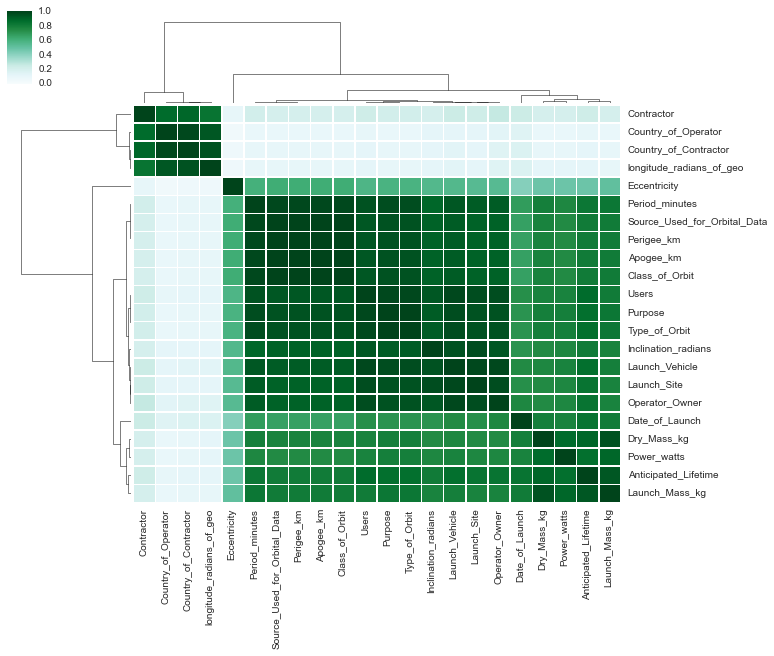

In [13]:
satellites.heatmap("""ESTIMATE DEPENDENCE PROBABILITY FROM PAIRWISE COLUMNS OF %g;""");

This heatmap shows several groups of variables with high probability of mutual interdependence. For example, we see a definite block of geopolitically related variables, such as the country of contractor & operator, the contractor's identity, and the location of the satellite (if it is in geosynchronous orbit). The kinematic variables describing orbits, such as perigee, apogee, period, and orbit class, are also shown as strongly interdependent. A domain expert with sufficiently confident domain knowledge can thus use this overview of the predictive relationships to critically assess the value of the data and the efficacy of MML.

It is also instructive to compare the heatmap of pairwise dependence probabilities with standard alternatives from statistics, such as datatype-appropriate measures of correlation:

BQL [ESTIMATE CORRELATION FROM PAIRWISE COLUMNS OF "satellites_cc";] ()

Detected value limits as [0, 1]. Override with vmin and vmax.


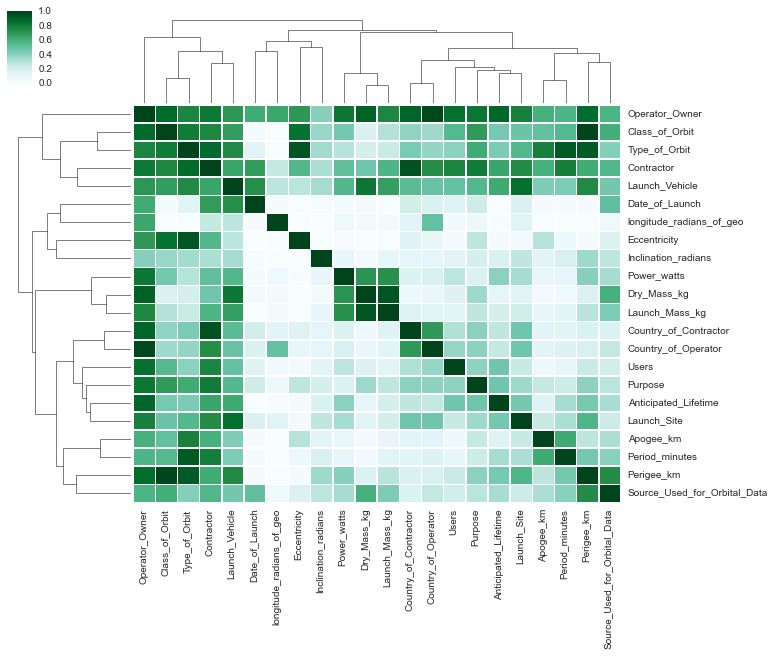

In [14]:
# WARNING: This may take a couple minutes.
satellites.heatmap("""ESTIMATE CORRELATION FROM PAIRWISE COLUMNS OF %g;""");

The results from correlation are sufficiently noisy that it would be difficult to trust inferences from techniques that use correlation to select variables. Furthermore, the most causally unambiguous relationships, such as the geometric constraint relating perigee and apogee, are not detected by correlation.

## Querying the implications using BQL — Inferring missing values

A key step in data cleaning is choosing a method for handling missing values. BQL provides the INFER primitive to make it straightforward to obtain point estimates and confidence scores for arbitrary cells in the database.

Consider the variable `type_of_orbit`. It is easy to see that many values are missing:

In [15]:
satellites.q("""SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;""")

BQL [SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;] ()

,"""COUNT""(*)"
0,123


The following query produces a table with several variables, along with both a predicted value for `type_of_orbit` and the confidence associated with that value:

In [16]:
satellites.q("""DROP TABLE IF EXISTS "inferred_orbit";""")
satellites.q("""
CREATE TEMP TABLE IF NOT EXISTS inferred_orbit AS
    INFER EXPLICIT anticipated_lifetime, perigee_km,
        period_minutes, class_of_orbit,
        PREDICT type_of_orbit AS inferred_orbit_type
            CONFIDENCE inferred_orbit_type_conf
    FROM %g
        WHERE type_of_orbit IS NULL;
""")

BQL [DROP TABLE IF EXISTS "inferred_orbit";] ()

BQL [
CREATE TEMP TABLE IF NOT EXISTS inferred_orbit AS
 INFER EXPLICIT anticipated_lifetime, perigee_km,
 period_minutes, class_of_orbit,
 PREDICT type_of_orbit AS inferred_orbit_type
 CONFIDENCE inferred_orbit_type_conf
 FROM "satellites_cc"
 WHERE type_of_orbit IS NULL;
] ()

""


We can visualize the result both in tabular and graphical form.

In [17]:
satellites.q("""SELECT * FROM inferred_orbit LIMIT 30;""")

BQL [SELECT * FROM inferred_orbit LIMIT 30;] ()

,anticipated_lifetime,perigee_km,period_minutes,class_of_orbit,inferred_orbit_type,inferred_orbit_type_conf
0,1.0,770,100.42,LEO,Sun-Synchronous,0.81
1,NaN,480,97.40,LEO,Sun-Synchronous,0.59
2,NaN,495,97.50,LEO,Sun-Synchronous,0.69
3,NaN,499,97.60,LEO,Sun-Synchronous,0.79
4,2.0,443,98.00,LEO,Sun-Synchronous,0.77
5,2.0,443,98.00,LEO,Sun-Synchronous,0.74
6,3.0,510,95.10,LEO,Sun-Synchronous,0.53
7,2.0,570,96.20,LEO,Sun-Synchronous,0.69
8,NaN,599,96.90,LEO,Sun-Synchronous,0.76
9,3.0,558,96.06,LEO,Sun-Synchronous,0.74


BQL [
SELECT inferred_orbit_type, inferred_orbit_type_conf, class_of_orbit
FROM inferred_orbit;
] ()

/Users/probcomp/GoogleDrive/ProbComp/venv-2.7.11-0.1.4/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/probcomp/GoogleDrive/ProbComp/venv-2.7.11-0.1.4/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


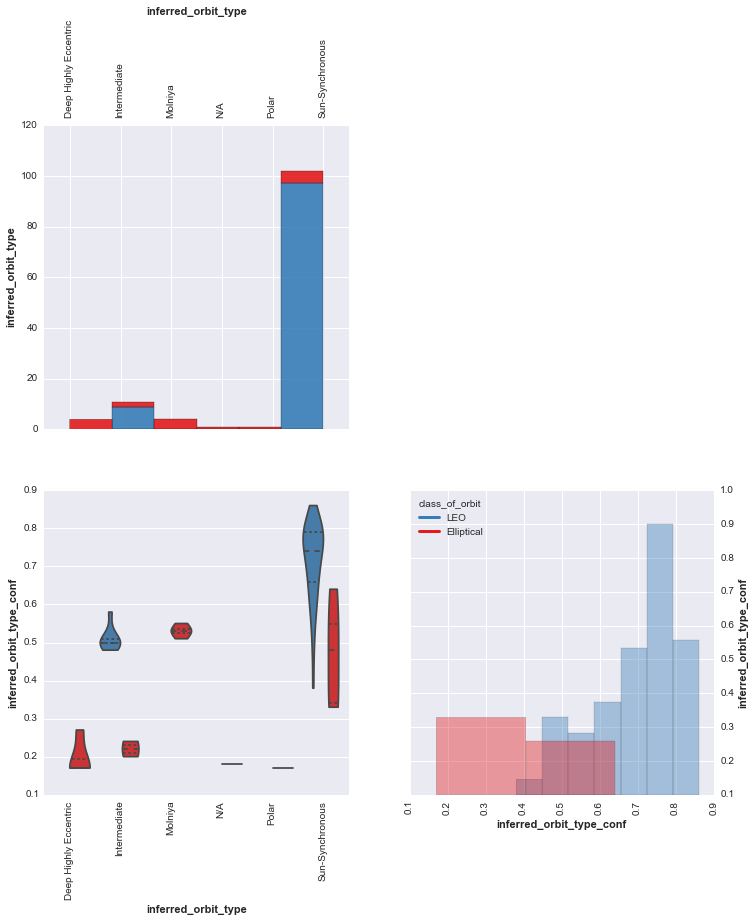

In [18]:
satellites.pairplot("""
SELECT inferred_orbit_type, inferred_orbit_type_conf, class_of_orbit
FROM inferred_orbit;
""", 
                    colorby='class_of_orbit');

The plot on the bottom left shows that the confidence depends on the orbit class and on the predicted value for the inferred orbit type. For example, there is typically moderate to high confidence for the orbit type of `LEO` satellites — and high confidence (but some variability in confidence) for those with `Sun-Synchronous` orbits. Satellites with `Elliptical` orbits may be assigned a `Sun-Synchronous` type with moderate confidence, but for other target labels confidence is generally lower.

Note that many standard techniques for imputation from statistics correspond to INFER ... WITH CONFIDENCE 0, as they have no natural notion of confidence.

## Query the implications using BQL — Identify anomalies

Another core data cleaning operation is identifying erroneous values — including (univariate) outliers and other kinds of anomalies. BQL makes it straightforward to assess the predictive probability density of each cell in the data.

Recall earlier that we mentioned that some of the relations are governed by
the laws of physics and are thus nearly deterministic? We can use this
determinism coupled with our notion of anomalousness to search the table for
data-entry errors. A geosynchronous orbit should take 24 hours
(1440 minutes). Let us display the anomalous values for satellites in
geosynchronous orbit.

In [19]:
satellites.q("""DROP TABLE IF EXISTS "unlikely_periods";""")
satellites.q("""
CREATE TEMP TABLE IF NOT EXISTS unlikely_periods AS
    ESTIMATE name, class_of_orbit, period_minutes,
        PREDICTIVE PROBABILITY OF period_minutes
            AS "Relative Probability of Period"
    FROM %g;
""")

BQL [DROP TABLE IF EXISTS "unlikely_periods";] ()

BQL [
CREATE TEMP TABLE IF NOT EXISTS unlikely_periods AS
 ESTIMATE name, class_of_orbit, period_minutes,
 PREDICTIVE PROBABILITY OF period_minutes
 AS "Relative Probability of Period"
 FROM "satellites_cc";
] ()

""


In [20]:
satellites.q("""
SELECT * FROM unlikely_periods
    WHERE class_of_orbit = 'GEO'
        AND period_minutes IS NOT NULL
    ORDER BY "Relative Probability of Period" ASC LIMIT 10;
""")

BQL [
SELECT * FROM unlikely_periods
 WHERE class_of_orbit = 'GEO'
 AND period_minutes IS NOT NULL
 ORDER BY "Relative Probability of Period" ASC LIMIT 10;
] ()

,Name,Class_of_Orbit,Period_minutes,Relative Probability of Period
0,AEHF-3 (Advanced Extremely High Frequency sate...,GEO,1306.29,0.001295
1,AEHF-2 (Advanced Extremely High Frequency sate...,GEO,1306.29,0.001295
2,DSP 20 (USA 149) (Defense Support Program),GEO,142.08,0.002638
3,Intelsat 903,GEO,1436.16,0.003249
4,BSAT-3B,GEO,1365.61,0.003418
5,Intelsat 902,GEO,1436.10,0.003443
6,"SDS III-6 (Satellite Data System) NRO L-27, Gr...",GEO,14.36,0.003735
7,"Advanced Orion 6 (NRO L-15, USA 237)",GEO,23.94,0.003863
8,"SDS III-7 (Satellite Data System) NRO L-38, Dr...",GEO,23.94,0.003863
9,"QZS-1 (Quazi-Zenith Satellite System, Michibiki)",GEO,1436.00,0.004522


We see a couple of oddities. There are satellites with 24-minute periods. It
appears that these entries are in hours rather than minutes. There are other
entries that have too-short periods, which appear to be decimal errors.


**NOTE:** We have reported these errors to the database maintainers.

# Request for help to improve the database

We need your help to improve the quality of this database and BayesDB snapshot. Here are some ideas to get you started:

**Detecting and patching bad data.** We've found many ETL errors using simple queries that find satellites with the least likely measured values. This dataset appears to have been mirrored many times, so fixing errors could help many downstream users.

**Assuring model and inference quality.** We've shown our exploratory analysis to domain experts from NASA and to MIT colleagues. How much room is there to improve results by customizing the model and fixing inference quality bugs? and how easy is it for domain experts to distinguish between model problems, data problems, and their own misconceptions?

We're also interested in exploring new applications. For example:

**Build a satellite search engine for satellite spotters.** This could answer queries like "I see a satellite with a particular velocity that I know is not a communications satellite. What are the most probable matches?"


**What-if scenarios.**  Given a new Chinese project to launch a communications satellite, who are the most likely contractors? and how heavy is it likely to be? What about if it had been launched in 1970?

**If you are a satellite (or satellite industry) enthusiast, and want to help out, please contact us about additional possibilities, such as as mapping the characteristics of contractors or automatically finding similar contractors and launch sites. These applications require analyzing other populations that can be derived from the same data source.**


--------------------------------------------

Copyright (c) 2010-2016, MIT Probabilistic Computing Project

Licensed under Apache 2.0 (edit cell for details).

<!--
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
-->